In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',100)

basket_df = pd.read_csv("./csv_files/Trans_by_Basket_50000_Cust_YA_no_XX.csv",parse_dates=[23])

print(basket_df.shape)

basket_df = basket_df.drop(columns = ['basket_id.1','time_id.1','cust_id.1','store_id.1'])

#Find an average frequency between visits?

basket_df_time = basket_df[['cust_id','shop_date']]

#asket_df_time.head(100)

#Unique_Cust = basket_df_time['cust_id'].unique()

#rint(Unique_Cust)


#for cust in Unique_Cust[1:10]:
#    excursion = basket_df_time[basket_df_time['cust_id']==cust]['shop_date']
#    print(excursion.diff)

test = pd.DataFrame(columns = ['date','diff'])

#df.groupby('item_id')['date'].diff()

test['date'] = basket_df_time.groupby('cust_id')['shop_date'].apply(lambda x: x.sort_values())
#test['diff'] = test['date'].diff() / np.timedelta64(1, 'D')

test['diff'] = test.groupby('cust_id')['date'].diff() / np.timedelta64(1, 'D')

test = test.dropna()
    
#print(test)

date_diff = test.groupby('cust_id')['diff'].agg(['min', 'max','mean'])
#test.describe()

date_diff.columns = ['shop_diff_min','shop_diff_max','shop_diff_mean']

print(date_diff.describe())

(50000, 25)
       shop_diff_min  shop_diff_max  shop_diff_mean
count     527.000000     527.000000      527.000000
mean        1.599620     118.700190       19.759234
std         8.302563     134.780477       28.110834
min         0.000000       6.000000        1.043367
25%         0.000000      34.000000        5.652264
50%         0.000000      63.000000       10.061728
75%         1.000000     153.500000       22.942017
max       153.000000     719.000000      297.000000


In [282]:
X = basket_df[['store_id','std_quantity','nunique_products',
              'n_products','sum_spend','cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission','store_format','store_region']]

#X['cust_lifestage'].fillna('OT')

#Groupby Customer
scaler = StandardScaler()

# Need to Dummy my variables first

X_cat = X[['cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission']]
X_num = X[['std_quantity','nunique_products','n_products','sum_spend']]

X_dum = pd.get_dummies(X_cat)
#X_num_scale = pd.DataFrame(scaler.fit_transform(X_num),columns=['std_quantity','nunique_products','n_products','sum_spend'])
           
X_all = pd.concat([X_num,X_dum],axis=1)

X_all = pd.concat([basket_df['cust_id'],X_all],axis=1)

X_all_cust_grp  = X_all.groupby('cust_id').agg({ 'std_quantity' : ['mean'],
                            'nunique_products' : ['mean'],
                            'n_products': ['mean'],
                            'sum_spend': ['mean','max'],
                            'cust_price_sensitivity_LA': ['max'],
                            'cust_price_sensitivity_MM': ['max'],
                            'cust_price_sensitivity_UM': ['max'],
                            'basket_size_L' : ['max', 'sum','count'],
                            'basket_size_M' : ['max', 'sum'],
                            'basket_size_S' : ['max', 'sum'],
                            'basket_price_sensitivity_LA' : ['max', 'sum'],
                            'basket_price_sensitivity_MM' : ['max', 'sum'],
                            'basket_price_sensitivity_UM' : ['max', 'sum'],
                            'basket_type_Full Shop' : ['max', 'sum'], 
                            'basket_type_Small Shop': ['max', 'sum'], 
                            'basket_type_Top Up': ['max', 'sum'],
                            'basket_dominant_mission_Fresh': ['max', 'sum'],
                            'basket_dominant_mission_Grocery': ['max', 'sum'],
                            'basket_dominant_mission_Mixed': ['max', 'sum'],
                            'basket_dominant_mission_Nonfood': ['max', 'sum'] })

X_all_cust_grp.columns = ["_".join(x) for x in X_all_cust_grp.columns.ravel()]

sum_columns = ['basket_size_L_sum', 
               'basket_size_M_sum', 
               'basket_size_S_sum', 
               'basket_price_sensitivity_LA_sum', 
               'basket_price_sensitivity_MM_sum', 
               'basket_price_sensitivity_UM_sum',
               'basket_type_Full Shop_sum', 
               'basket_type_Small Shop_sum', 
               'basket_type_Top Up_sum', 
               'basket_dominant_mission_Fresh_sum',
               'basket_dominant_mission_Grocery_sum',
               'basket_dominant_mission_Mixed_sum',
               'basket_dominant_mission_Nonfood_sum']

for col in sum_columns:
    X_all_cust_grp[col] = X_all_cust_grp[col] / X_all_cust_grp['basket_size_L_count']

X_all_cust_grp.rename(columns={"basket_size_L_count": "basket_count"})

X_all_cust_grp = pd.concat([X_all_cust_grp,date_diff],axis=1)

X_all_cust_grp.head()

X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
                                    columns=X_all_cust_grp.columns,index=X_all_cust_grp.index)

X_all_cust_grp = X_all_cust_grp[ ~X_all_cust_grp_scale.isna().any(axis=1) ] 

X_all_cust_grp_scale = X_all_cust_grp_scale.dropna()


/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [283]:
pca_grp = PCA(n_components = 0.8)

X_all_cust_grp_scale_pca = pca_grp.fit_transform(X_all_cust_grp_scale)

#plt.bar(['PC1', 'PC2','PC3','PC4'], [0:3])

#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance Ratio')

pca_grp.explained_variance_ratio_


array([0.22736846, 0.11634759, 0.09527199, 0.06388215, 0.05528814,
       0.05084316, 0.03636033, 0.03410353, 0.02930211, 0.02772977,
       0.02687562, 0.02540524, 0.0204597 ])

In [284]:
import itertools

#X_all_cust_grp.drop(columns='cust_id')

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
#                                    columns=X_all_cust_grp.columns)

agg_model_list = [ AgglomerativeClustering(affinity = 'cosine', linkage = linkage, 
                  n_clusters = number).fit(X_all_cust_grp_scale_pca) for linkage,number in model_iterator]

agg_model_sil_list = [silhouette_score(X_all_cust_grp_scale_pca,model.labels_, metric = 'cosine') for model in agg_model_list]

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

agg_model_all_df = pd.DataFrame(model_iterator, columns =['linkage','n_comp'])

agg_model_all_df['sil'] = agg_model_sil_list 

#sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

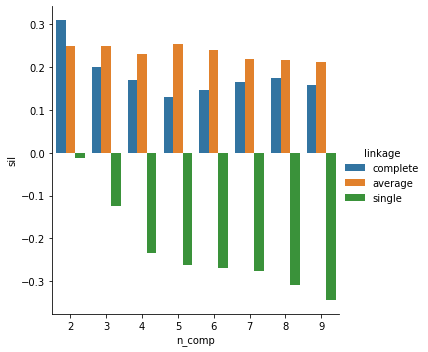

In [285]:
sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

In [286]:
best_agg_model = AgglomerativeClustering(affinity = 'cosine', linkage = 'complete', 
                  n_clusters = 2).fit(X_all_cust_grp_scale_pca) 

X_zero = X_all_cust_grp_scale.iloc[best_agg_model.labels_==0]

X_one = X_all_cust_grp_scale.iloc[best_agg_model.labels_==1]

#X_two = X_all_cust_grp.iloc[best_agg_model.labels_==2]
#print(X_zero.describe().T)
#print(X_one.describe().T)

print(X_zero.shape[0])
print(X_one.shape[0])

A = (X_zero.describe().T/X_zero.shape[0] - X_one.describe().T/X_one.shape[0])*(X_zero.shape[0]+X_one.shape[0])

print(A.sort_values(by ='mean', ascending=False))

316
211
                                     count      mean       std        min  \
basket_type_Small Shop_sum             0.0  3.306814 -0.616059   3.564191   
basket_size_S_sum                      0.0  2.824468  0.161899   1.295230   
basket_size_M_sum                      0.0  1.806762 -0.765467   1.966569   
basket_dominant_mission_Grocery_sum    0.0  1.239972 -0.132143   1.157746   
basket_size_S_max                      0.0  0.966368 -2.480634   2.913559   
basket_dominant_mission_Nonfood_sum    0.0  0.919463 -0.154191   0.698229   
basket_dominant_mission_Nonfood_max    0.0  0.754647 -1.183576   1.338535   
basket_type_Small Shop_max             0.0  0.631193 -3.209828  13.671449   
basket_dominant_mission_Fresh_sum      0.0  0.499403 -0.878407   2.315936   
basket_size_L_count                    0.0  0.451117  0.150369   0.783176   
basket_price_sensitivity_LA_max        0.0  0.397598 -1.337041   2.352305   
basket_price_sensitivity_MM_sum        0.0  0.381616 -1.177344   3.1

Text(0.5, 1.0, 'Mean Differences Between Groups (Scaled)')

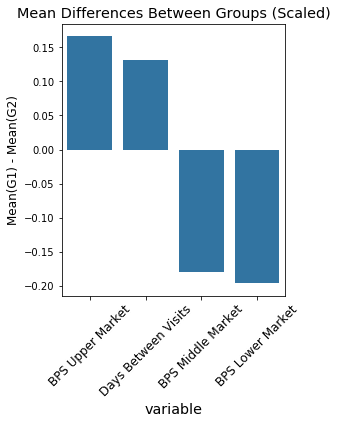

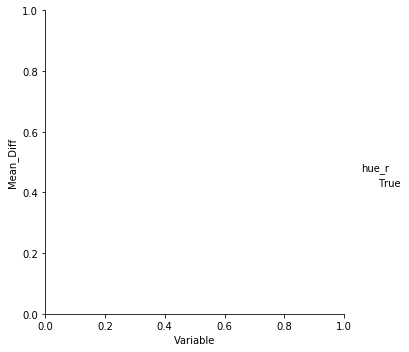

In [370]:
#Bar plot of above....
import scipy.stats as stats

results = [] ; 

test_index = ['basket_price_sensitivity_UM_sum',
                        'shop_diff_mean',
                        'basket_price_sensitivity_MM_max',
                        'basket_price_sensitivity_LA_max',
                        
                        ]
for var in test_index:
    
    mean_diff = X_zero[var].mean() - X_one[var].mean()

    results.append([var,X_zero[var].mean(),X_one[var].mean(), -1*mean_diff, stats.f_oneway(X_zero[var], X_one[var])[0],stats.f_oneway(X_zero[var], X_one[var])[1] ])

results_df = pd.DataFrame(results,columns = ['Variable','Group_1_mean','Group_2_mean','Mean_Diff','Fstat','P_value'])

#results_df = results_df.sort_values(by = 'Mean_Diff', ascending=False)

results_df['hue_r'] = results_df['Mean_Diff']<3

#plt.rcParams["figure.figsize"] = (8=20, 4)
fig_dims = (4, 5)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.catplot(x='Variable',y='Mean_Diff',data=results_df,hue='hue_r',kind='bar', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels(['BPS Upper Market','Days Between Visits','BPS Middle Market','BPS Lower Market'],fontsize='large')
ax.set_xlabel('variable',fontsize='x-large')
ax.set_ylabel('Mean(G1) - Mean(G2)',fontsize='large')
ax.set_title('Mean Differences Between Groups (Scaled)',fontsize='x-large')


In [330]:
results_df

,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value
0,basket_price_sensitivity_LA_max,0.110739,-0.085247,0.195987,5.322108,0.021445
1,basket_price_sensitivity_MM_max,0.106701,-0.072989,0.179690,6.083106,0.013966
3,shop_diff_mean,-0.052544,0.078692,-0.131236,2.179796,0.140433
2,basket_price_sensitivity_UM_sum,-0.069903,0.096552,-0.166455,3.683948,0.055480


In [ ]:


X_all_cust_grp.head()


In [ ]:

X_zero_p = X_all_cust_grp.iloc[best_agg_model.labels_==0]

X_one_p = X_all_cust_grp.iloc[best_agg_model.labels_==1]

print('Group_0 total spend',(X_zero_p['sum_spend_mean']*X_zero_p['basket_size_L_count']).sum())
print('Group_1 total spend',(X_one_p['sum_spend_mean']*X_one_p['basket_size_L_count']).sum())

In [ ]:
print(X_zero.shape[0])
print(X_one.shape[0])

In [ ]:
results_df.head()


In [ ]:
print(results_df['Variable'] == 'basket_type_Small Shop_sum')

In [ ]:
results_df['Variable'] == ["basket_size_S_sum"]

In [333]:
hue_r

0     True
1     True
3    False
2    False
Name: Mean_Diff, dtype: bool